In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints, transforms
from pyro.infer import Predictive, TracePredictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from patsy import dmatrix
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (9, 4)

# Chapter 5 - Splines

## 5.5 - Fitting splines in Pyro

In [2]:
day = pd.read_csv('./data/Bike-Sharing-Dataset/day.csv')
hour = pd.read_csv('./data/Bike-Sharing-Dataset/hour.csv')
hour['cnt_std'] = hour['cnt'] / hour['cnt'].max()

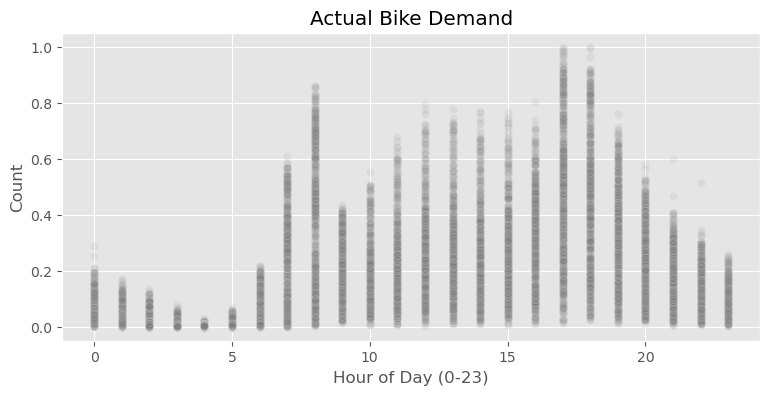

In [4]:
sns.scatterplot(x=hour['hr'], y=hour['cnt_std'], alpha=0.1, color='grey')
plt.ylabel('Count')
plt.xlabel('Hour of Day (0-23)')
plt.title('Actual Bike Demand');

In [6]:
num_knots = 6
knot_list = torch.linspace(0, 23, num_knots + 2)[1:-1]

B = dmatrix(
    "bs(cnt_std, knots=knots, degree=3, include_intercept=True) - 1",
    {'cnt_std': hour.hr.values, 'knots': knot_list[1:-1]}
)

B = torch.tensor(np.asarray(B)).float()
cnt_bikes = torch.tensor(hour['cnt_std'].values).float()
hour_bikes = torch.tensor(hour['hr'].values).reshape(-1, 1).float()

### Splines Model - MCMC

In [7]:
def splines(design_matrix, count_bikes=None):

    N, P = design_matrix.shape

    tau = pyro.sample('tau', dist.HalfCauchy(1.))
    sigma = pyro.sample('sigma', dist.HalfNormal(1.))

    with pyro.plate('knot_list', P):
        beta = pyro.sample('beta', dist.Normal(0., tau))

    mu = pyro.deterministic('mu', torch.matmul(beta, design_matrix.T))

    with pyro.plate('output', N):
        output = pyro.sample('y', dist.Normal(mu, sigma), obs=count_bikes)


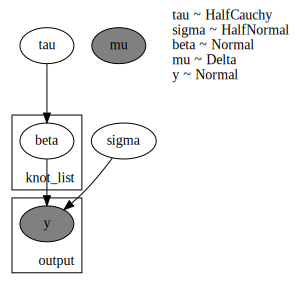

In [8]:
pyro.render_model(
    splines, (B, cnt_bikes), render_distributions=True
)

In [9]:
kernel = NUTS(splines)
mcmc_splines = MCMC(kernel, 500, 300)
mcmc_splines.run(B, cnt_bikes)

Sample: 100%|██████████| 800/800 [00:12, 62.91it/s, step size=2.93e-01, acc. prob=0.887]


In [10]:
prior_predictive = Predictive(splines, num_samples=500)(B, None)
spline_samples = mcmc_splines.get_samples(500)
splines_predictive = Predictive(splines, spline_samples)(B, None)

az_splines_pred = az.from_pyro(
    prior=prior_predictive,
    posterior=mcmc_splines, 
    posterior_predictive=splines_predictive
    )

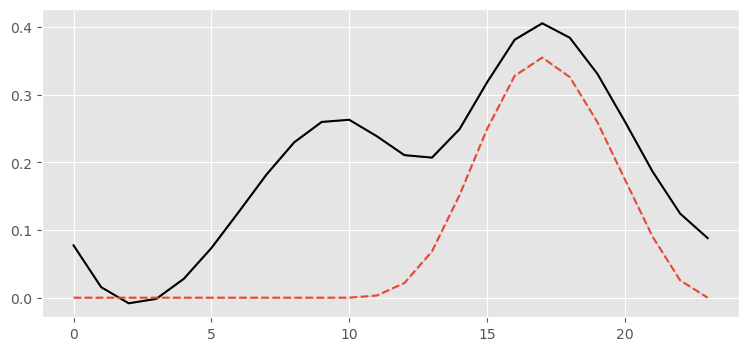

In [11]:
sns.lineplot(
    x=hour_bikes.flatten(), y=splines_predictive['mu'].mean(axis=0).T.flatten(),
    color='black'
    )
sns.lineplot(
    x=hour_bikes.flatten(), y=(B * spline_samples['beta'].mean(axis=0))[:, 5],
    linestyle='--'
    );

In [ ]:
cnt_mu = splines_predictive['y'].mean(axis=0).T.flatten()
cnt_std = splines_predictive['y'].std(axis=0).T.flatten()

df = pd.DataFrame({
    'hr': hour['hr'].values,
    'cnt_scaled': hour['cnt_std'].values,
    'cnt_mu': cnt_mu,
    'cnt_std': cnt_std,
    'cnt_high': cnt_mu + cnt_std,
    'cnt_low': cnt_mu - cnt_std
})

df = df.sort_values(by=['hr'])

### Figure 5.9

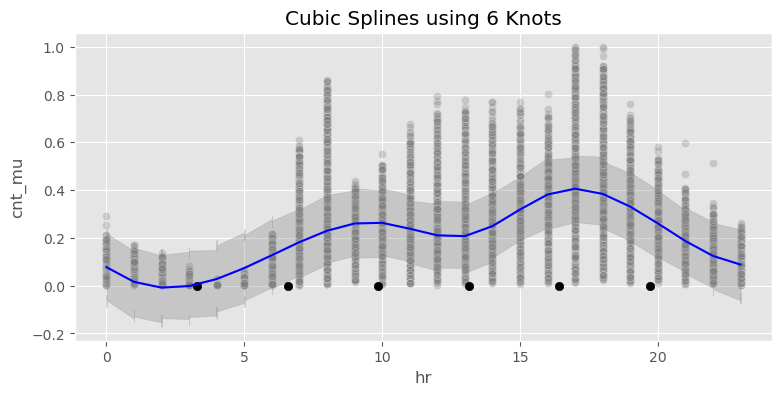

In [13]:
sns.lineplot(
    x=df['hr'], y=df['cnt_mu'], color='blue')
sns.scatterplot(
    x=hour['hr'], y=hour['cnt_std'], color='grey', alpha=0.3
    )
plt.fill_between(
    x=df['hr'], y1=df['cnt_high'], y2=df['cnt_low'], color='grey',
    alpha=0.3
    )
plt.scatter(knot_list, np.zeros_like(knot_list), color='black')
plt.title('Cubic Splines using 6 Knots');

## 5.6 - Choosing knots and priors for splines

In [14]:
Bs = []
num_knots = [3, 6, 9, 12, 18]
for nk in num_knots:
    knot_list = torch.linspace(0, 24, nk+2)[1:-1]
    B = dmatrix(
        'bs(cnt, knots=knots, degree=3, include_intercept=True) - 1',
        {'cnt': hour.hr.values, 'knots': knot_list[1:-1]}
    )
    B = torch.tensor(np.asarray(B)).float()
    Bs.append(B)

In [69]:
inf_data = []
for B in Bs:

    mcmc_obj = MCMC(NUTS(splines), 500, 300)
    mcmc_obj.run(B, cnt_bikes)

    post_samples = mcmc_obj.get_samples(500)
    post_pred = Predictive(
        splines, post_samples
    )(B, None)

    az_obj = az.from_pyro(
        posterior=mcmc_obj,
        posterior_predictive=post_pred
    )

    inf_data.append(az_obj)

Sample: 100%|██████████| 800/800 [00:17, 45.97it/s, step size=2.59e-01, acc. prob=0.890]


In [70]:
# something is not right here
dict_cmp = {f"m_{k}k": v for k, v in zip(num_knots, inf_data)}
cmp = az.compare(dict_cmp, ic='loo', var_name='y')
cmp

['m_18k', 'm_12k', 'm_9k', 'm_6k', 'm_3k']


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m_3k,0,10575.715589,20.874493,0.000000,0.850828,129.781140,0.000000,False,log
m_6k,1,10423.693963,14.518533,152.021626,0.000000,131.808422,19.387344,False,log
m_9k,2,10094.535427,12.458113,481.180162,0.000000,133.635244,36.071652,False,log
m_12k,3,9580.695289,8.562018,995.020300,0.000000,136.447458,53.955052,False,log
m_18k,4,8600.222467,6.347949,1975.493122,0.149172,142.746908,81.838699,False,log


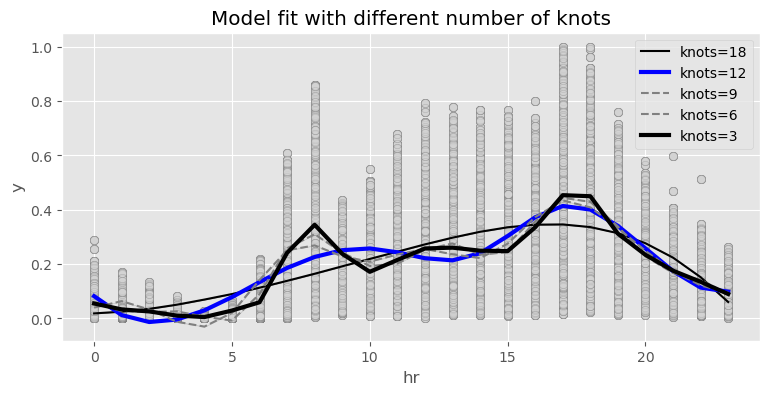

In [68]:
colors = ['black', 'blue', 'grey', 'grey', 'black']
linestyle = ["-","-","--","--","-"]
linewidth = [1.5, 3, 1.5, 1.5, 3]

for ob, col, knots, ls, lw in zip(
    inf_data, colors, sorted(num_knots, reverse=True), linestyle, linewidth
    ):

    sns.lineplot(
    x=hour['hr'], y=ob['posterior_predictive']['y'][0].mean(axis=0), color=col,
    label=f'knots={knots}', linestyle=ls, linewidth=lw
    )
    sns.scatterplot(
    x=hour['hr'], y=hour['cnt_std'].values, color='lightgrey', alpha=0.5, edgecolor='grey'
    )
    plt.title('Model fit with different number of knots');

### 5.6.1 Regularizing priors for splines

In [71]:
class GaussianRandomWalk(dist.TorchDistribution):
    has_rsample = True
    arg_constraints = {'scale': constraints.positive}
    support = constraints.real

    def __init__(self, scale, num_steps=1):
        self.scale = scale
        batch_shape, event_shape = scale.shape, torch.Size([num_steps])
        super(GaussianRandomWalk, self).__init__(batch_shape, event_shape)
    
    def rsample(self, sample_shape=torch.Size()):
        shape = sample_shape + self.batch_shape + self.event_shape
        walks = self.scale.new_empty(shape).normal_()
        return walks.cumsum(-1) * self.scale.unsqueeze(-1)
    
    def log_prob(self, x):
        init_prob = dist.Normal(self.scale.new_tensor(0.), self.scale).log_prob(x[..., 0])
        step_probs = dist.Normal(x[..., :-1], self.scale).log_prob(x[..., 1:])
        return init_prob + step_probs.sum(-1)

In [77]:
def splines_grw(design_matrix, count_bikes=None):

    N, P = design_matrix.shape

    tau = pyro.sample('tau', dist.HalfCauchy(1.))
    sigma = pyro.sample('sigma', dist.HalfNormal(1.))

    with pyro.plate('knot_list', P):
        beta = pyro.sample('beta', GaussianRandomWalk(scale=tau, num_steps=14))

    mu = pyro.deterministic('mu', torch.matmul(beta, design_matrix.T))

    with pyro.plate('output', N):
        output = pyro.sample('y', dist.Normal(mu, sigma), obs=count_bikes)

In [73]:
num_knots = 12
knot_list = torch.linspace(0, 23, num_knots + 2)[1:-1]

B = dmatrix(
    "bs(cnt_std, knots=knots, degree=3, include_intercept=True) - 1",
    {'cnt_std': hour.hr.values, 'knots': knot_list[1:-1]}
)

B = torch.tensor(np.asarray(B)).float()
cnt_bikes = torch.tensor(hour['cnt_std'].values).float()
hour_bikes = torch.tensor(hour['hr'].values).reshape(-1, 1).float()

In [78]:
splines_grw_mcmc = MCMC(NUTS(splines_grw), 500, 300)
splines_grw_mcmc.run(B, cnt_bikes)

Sample: 100%|██████████| 800/800 [01:48,  7.40it/s, step size=1.51e-01, acc. prob=0.878]


In [79]:
splines_grw_mcmc.summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta[0,0]      0.06      0.00      0.06      0.05      0.06    793.18      1.00
  beta[0,1]     -0.00      0.01     -0.00     -0.02      0.02    543.60      1.00
  beta[0,2]      0.07      0.01      0.07      0.05      0.08    539.25      1.00
  beta[0,3]     -0.07      0.01     -0.07     -0.08     -0.05    593.26      1.00
  beta[0,4]      0.32      0.01      0.32      0.31      0.34    598.96      1.00
  beta[0,5]      0.30      0.01      0.30      0.29      0.32    647.04      1.00
  beta[0,6]      0.10      0.01      0.10      0.09      0.12    580.51      1.00
  beta[0,7]      0.34      0.01      0.34      0.33      0.36    588.65      1.00
  beta[0,8]      0.19      0.01      0.19      0.18      0.20    556.40      1.00
  beta[0,9]      0.31      0.01      0.31      0.30      0.32    542.28      1.00
 beta[0,10]      0.56      0.01      0.56      0.55      0.58    614.87      1.00
 beta[0,11]    

In [82]:
splines_grw_samples = splines_grw_mcmc.get_samples(1000)
splines_grw_post_pred = Predictive(
    splines_grw,
    splines_grw_samples
)(B, None)

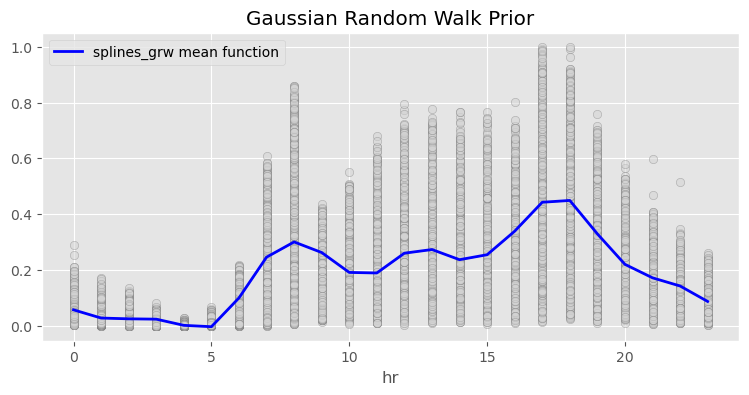

In [100]:
# mean -> mean b/c I take mean of GRW first, then mean of
# 1000 posterior samples
sns.lineplot(
    x=hour['hr'], y=splines_grw_post_pred['y'].mean(axis=1).mean(axis=0), 
    color='blue', lw=2, label='splines_grw mean function'
    )
sns.scatterplot(
    x=hour['hr'], y=hour['cnt_std'].values, 
    color='lightgrey', alpha=0.5, edgecolor='grey'
    )
plt.title('Gaussian Random Walk Prior');

## Modeling $\text{CO}_2$ Uptake with Splines

In [2]:
plants_CO2 = pd.read_csv("./data/CO2_uptake.csv")
plant_names = plants_CO2.Plant.unique()
CO2_conc = plants_CO2.conc.values[:7]
CO2_concs = plants_CO2.conc.values
uptake = plants_CO2.uptake.values
index = range(12)
groups = len(index)

In [3]:
num_knots = 2
knot_list = np.linspace(CO2_conc[0], CO2_conc[-1], num_knots+2)[1:-1]

Bg = dmatrix(
    "bs(conc, knots=knots, degree=3, include_intercept=True) - 1",
    {"conc": CO2_concs, "knots": knot_list},
)

Bg = torch.tensor(np.asarray(Bg)).float()
uptake = torch.tensor(uptake).float()

### Pooled Model - MCMC

In [4]:
def single_response(design_matrix, obs=None):

    N, P = design_matrix.shape
    
    tau = pyro.sample('tau', dist.HalfCauchy(1.))
    sigma = pyro.sample('sigma', dist.HalfNormal(1.))

    with pyro.plate('coef', P):
        beta = pyro.sample('beta', dist.Normal(0., tau))

    ug = pyro.deterministic('ug', torch.matmul(beta, design_matrix.T))

    with pyro.plate('obs', N):
        up = pyro.sample('uptake', dist.Normal(ug, sigma), obs=obs)

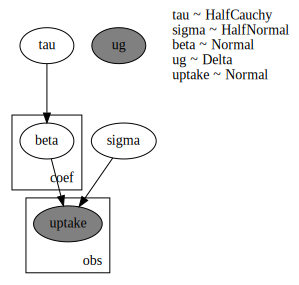

In [5]:
pyro.render_model(
    single_response,
    (Bg, uptake), 
    render_distributions=True
)

In [6]:
sr_mcmc = MCMC(NUTS(single_response), 500, 300)
sr_mcmc.run(Bg, uptake)

Sample: 100%|██████████| 800/800 [00:38, 20.99it/s, step size=1.98e-01, acc. prob=0.934]


In [7]:
sr_mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     12.21      1.82     12.27      9.20     15.06    261.26      1.00
   beta[1]     30.06      3.52     30.11     24.50     35.95    251.13      1.00
   beta[2]     30.06      6.05     29.81     20.25     39.69    193.86      1.00
   beta[3]     33.86      9.16     33.72     20.00     49.44    171.13      1.00
   beta[4]     25.27     22.92     24.96    -14.30     60.07    186.48      1.01
   beta[5]     33.41      2.03     33.29     30.06     36.65    395.37      1.00
     sigma      6.77      0.38      6.75      6.24      7.48    596.67      1.00
       tau     31.24     10.56     28.94     17.24     47.38    226.15      1.00

Number of divergences: 0


In [8]:
sr_samples = sr_mcmc.get_samples(1000)
sr_post_pred = Predictive(
    single_response, 
    sr_samples
)(Bg, None)

/Users/gabestechschulte/miniforge3/envs/probs/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


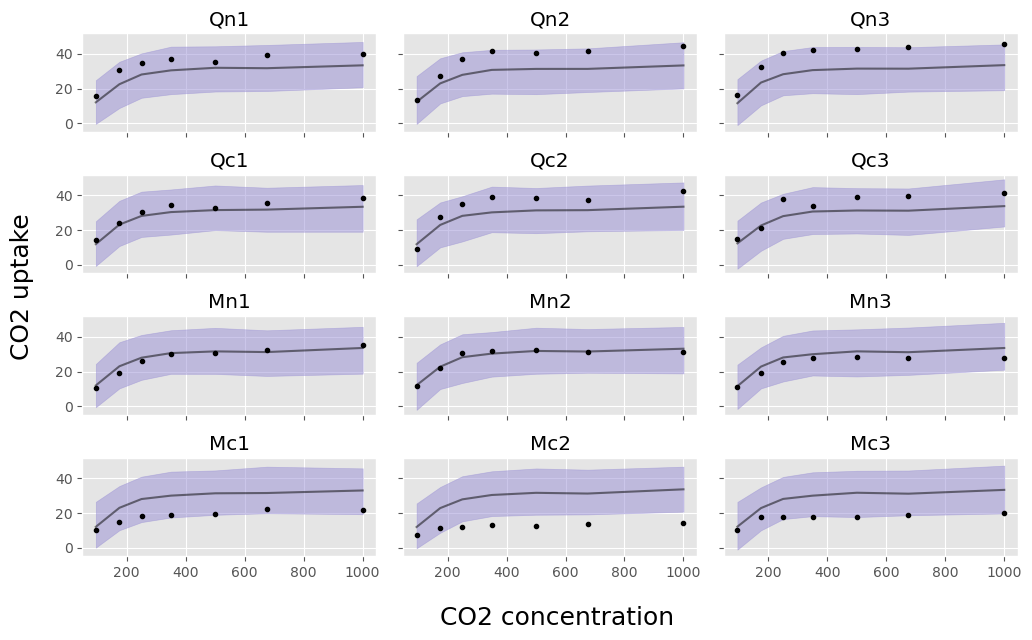

In [10]:
fig, axes = plt.subplots(4, 3, figsize=(10, 6), sharey=True, sharex=True)

for count, (idx, ax) in enumerate(zip(range(0, 84, 7), axes.ravel())):
    ax.plot(CO2_conc, uptake[idx:idx+7], '.', lw=1, color='black')
    ax.plot(CO2_conc, sr_post_pred['uptake'].mean(axis=0)[idx:idx+7], "k", alpha=0.5);
    az.plot_hdi(CO2_conc, sr_post_pred['uptake'][:,idx:idx+7], color="C2", smooth=False, ax=ax)
    ax.set_title(plant_names[count])

plt.tight_layout()
fig.text(0.4, -0.05, "CO2 concentration", size=18)
fig.text(-0.03, 0.4, "CO2 uptake", size=18, rotation=90);

In [11]:
num_knots = 2
knot_list = np.linspace(CO2_conc[0], CO2_conc[-1], num_knots+2)[1:-1]

Bi = dmatrix(
    "bs(conc, knots=knots, degree=3, include_intercept=True) - 1",
    {"conc": CO2_conc, "knots": knot_list},
)

Bi = torch.tensor(np.asarray(Bi)).float()

### Mixed Effects Model - MCMC

In [20]:
def individual_response(design_matrix, groups, obs=None):

    N, P = design_matrix.size()
    
    tau = pyro.sample('tau', dist.HalfCauchy(1.))
    sigma = pyro.sample('sigma', dist.HalfNormal(1.))
    beta = pyro.sample('beta', dist.Normal(0., tau).expand([P, groups]))
    ug = pyro.deterministic('ug', torch.matmul(design_matrix, beta))
    ug = ug[:, index].T.ravel()

    with pyro.plate('obs', ug.size(0)):
        up = pyro.sample('uptake', dist.Normal(ug, sigma), obs=obs)

In [21]:
ir_mcmc = MCMC(NUTS(individual_response), 500, 300)
ir_mcmc.run(Bi, groups, uptake)

Sample: 100%|██████████| 800/800 [01:03, 12.67it/s, step size=1.36e-01, acc. prob=0.895]


In [22]:
ir_mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
 beta[0,0]     15.89      2.02     15.80     12.85     19.17    749.09      1.00
 beta[0,1]     13.24      1.97     13.24     10.27     16.83    818.95      1.00
 beta[0,2]     16.11      2.09     16.17     13.20     20.12    861.96      1.00
 beta[0,3]     14.01      2.04     13.96     10.65     17.05   1070.16      1.00
 beta[0,4]      9.39      2.04      9.29      6.12     12.53    646.55      1.00
 beta[0,5]     13.72      2.06     13.76     10.31     17.12    797.97      1.00
 beta[0,6]     10.36      1.84     10.24      7.20     13.16    733.61      1.00
 beta[0,7]     11.61      1.96     11.58      8.36     14.59    499.54      1.00
 beta[0,8]     11.02      1.85     10.98      7.65     13.60    414.56      1.00
 beta[0,9]     10.31      1.97     10.33      6.76     13.22    907.83      1.01
beta[0,10]      7.64      2.00      7.59      4.22     10.82    602.67      1.00
beta[0,11]     10.94      2

In [23]:
ir_samples = ir_mcmc.get_samples(1000)
ir_post_pred = Predictive(
    individual_response, 
    ir_samples
)(Bi, groups, None)

/Users/gabestechschulte/miniforge3/envs/probs/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


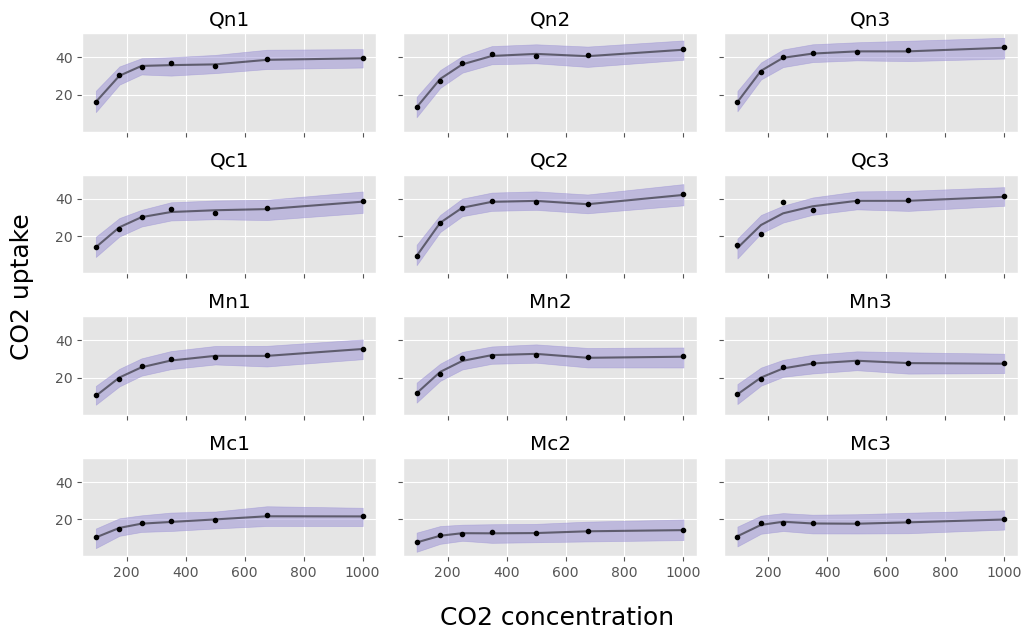

In [24]:
fig, axes = plt.subplots(4, 3, figsize=(10, 6), sharey=True, sharex=True)

for count, (idx, ax) in enumerate(zip(range(0, 84, 7), axes.ravel())):
    ax.plot(CO2_conc, uptake[idx:idx+7], '.', lw=1, color='black')
    ax.plot(CO2_conc, ir_post_pred['uptake'].mean(axis=0)[idx:idx+7], "k", alpha=0.5);
    az.plot_hdi(CO2_conc, ir_post_pred['uptake'][:,idx:idx+7], color="C2", smooth=False, ax=ax)
    ax.set_title(plant_names[count])

plt.tight_layout()
fig.text(0.4, -0.05, "CO2 concentration", size=18)
fig.text(-0.03, 0.4, "CO2 uptake", size=18, rotation=90);